In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/indiv_dim/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import os
from abc import ABC, abstractmethod
import h5py
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Union
from pathlib import Path
from scipy import stats
from dataclasses import dataclass
from src.utils._config import *
from src.utils._io import *
from src.utils.plot import *
from src.utils.binning import *
from src.spectra._definition import *
from src.idm._definition import *
import argparse
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm


In [2]:
# IDM visualization
from matplotlib.colors import LinearSegmentedColormap
def save_matrix(matrix, filename='matrix.svg', style='nature'):
    """Save matrix as clean SVG without margins."""
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # Colormap options
    if style == 'redblue':
        # Red-Blue diverging
        cmap = LinearSegmentedColormap.from_list('nature_rb', 
            ['#3B4992', '#FFFFFF', '#EE0000'])
    elif style == 'coolwarm':
        # More subtle red-blue diverging
        cmap = 'RdBu_r'
    elif style == 'purpleorange':
        cmap = 'PuOr'
    else:
        # Single-color gradient (blue)
        cmap = LinearSegmentedColormap.from_list('nature_blue',
            ['#FFFFFF', '#2B5A9B'])
    
    ax.imshow(matrix, cmap=cmap, vmax=1, vmin=-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

def zscore_matrix(matrix):
    """Z-score matrix."""
    return (matrix - np.mean(matrix)) / np.std(matrix)

def scale_matrix(matrix):
    """Scale to [-1, 1]"""
    return 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix)) - 1
    
def triu_to_matrix(flat_vals, n):
    """Convert flattened upper triangle to symmetric matrix."""
    matrix = np.zeros((n, n))
    triu_idx = np.triu_indices_from(matrix, k=1)
    matrix[triu_idx] = flat_vals
    matrix = matrix + matrix.T
    np.fill_diagonal(matrix, 1.0)
    return matrix

In [ ]:
rois = ['occipital', 'ventral', 'temporal', 'semantic', 'pmc']
# rois_names = {'occipital': 'OccC',
#               'ventral': 'VTC',
#               'temporal': 'LTC',
#               'semantic': 'SMC'}
rois_names = {'occipital': 'early',
              'ventral': 'ventral',
              'temporal': 'lateral',
              'semantic': 'temporoparietal'}

HOME_DIR = Path("/data/chan21/idim-debug-spectra/")
idm_roi_colors = sns.color_palette("magma", len(rois))

mpl.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")
bin_strategy = BinStrategy(
            type='logarithmic',
            density=3,
            start=1,
            stop=10_000
        )


roi_corrs = {}
roi_corrs_isc = {}
roi_split_corrs = {}
roi_split_corrs_isc = {}

roi_perm_corrs = {roi: [] for roi in rois}
roi_perm_corrs_isc = {roi: [] for roi in rois}
roi_perm_split_corrs = {roi: [] for roi in rois}
roi_perm_split_corrs_isc = {roi: [] for roi in rois}

roi_boot_corrs = {roi: [] for roi in rois}
roi_boot_corrs_isc = {roi: [] for roi in rois}
roi_split_boot_corrs = {roi: [] for roi in rois}
roi_split_boot_corrs_isc = {roi: [] for roi in rois}
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}


In [ ]:
def get_min_length(h5_data_path, subjects, movies):
    """Calculate minimum length across all subject pairs and movies."""
    try:
        with h5py.File(h5_data_path, 'r') as h5f:
            min_length = np.min([
                h5f[f"data/sub-NSD103_sub-NSD104_{movie}"]["observed"].shape[0] 
                for movie in movies
            ])
        return min_length
    except Exception as e:
        print(f"Error calculating min_length: {e}")
        # Return a default value or raise exception
        raise

def compute_idm_fp(args, movie=None):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    analysis = IDMAnalysis(cache, bin_strategy)
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path
    print(h5_data_path)

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)
    
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})


    if movie is not None:
        idms = []
        for movie in config.movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            with h5py.File(h5_data_path, 'r') as h5f:
                for i, i_subject in enumerate(subjects):
                    for j, j_subject in enumerate(subjects[i+1:], i+1):
                        spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                        for n_bin, bin_id in enumerate(unique_bins):
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                idms.append(np.moveaxis(all_spectra, -1, 0))
        return analysis, idms, anat_matrices

    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None

    idm_series = {}
    with h5py.File(h5_data_path, 'r') as h5f:
        # Initialize array to store all spectra    
        for movie in movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            # Load spectra for each subject pair
            for i, i_subject in enumerate(subjects):
                for j, j_subject in enumerate(subjects[i+1:], i+1):
                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                    for n_bin, bin_id in enumerate(unique_bins):
                        try:
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                        except Exception as e:
                            continue
                            #print(f"Error loading data for {i_subject}_{j_subject}_{movie}: {e}")
            idm_series[movie] = all_spectra

    idm_even_series = np.nanmean([idm_series[movie] for movie in movies[::2]], axis=0)
    idm_odd_series = np.nanmean([idm_series[movie] for movie in movies[1::2]], axis=0)
    
    even_idm, odd_idm = np.moveaxis(idm_even_series, -1, 0), np.moveaxis(idm_odd_series, -1, 0)
    if args.motion:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins
    else:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, unique_bins


for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/data/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )

    analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins = compute_idm_fp(args)
    movies = list(motion_matrices[0].keys())
    even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
    odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
    even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
    odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)

    if args.isc:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            _, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            corr, res1, res2 = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_anat),
                get_upper_triangle(odd_anat))
            correlations.append(corr)
            residual1.append(res1)
            residual2.append(res2)
        roi_corrs_isc[roi] = correlations
        print(roi, correlations)
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs_isc[roi] = diagonals
    else:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            # # Visualization
            # idm_e = - zscore_matrix(even_idm[n_bin])
            # idm_o = - zscore_matrix(odd_idm[n_bin])
            # # Set diagonal to 0
            # np.fill_diagonal(idm_e, np.min(idm_e))
            # np.fill_diagonal(idm_o, np.min(idm_o))
            # save_matrix(idm_e, filename=f"idm_even_diff_{n_bin}.svg", style='coolwarm')
            # save_matrix(idm_o, filename=f"idm_odd_diff_{n_bin}.svg", style='coolwarm')
            # if n_bin == 3:
            #     break
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            corr, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            correlations.append(corr)
            residual1.append(rx)
            residual2.append(ry)
        roi_corrs[roi] = correlations
        print(roi, correlations)
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs[roi] = diagonals




/data/chan21/idim-debug-spectra/results/cov_pmc_functional_perm/eigenspectra.h5
pmc [0.8371681101476207, 0.8470537816431036, 0.7024369939223207, 0.526717893366969, 0.48411418298764936, 0.30707901960736395, 0.2465437205805409, 0.26110584171261697, 0.10200997523769165]


- Compute bootstrapped IDM correlations

In [9]:


def bootstrap_idm_series(analysis, args, n_bootstraps=1000):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)

    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
        even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
        even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
        odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)
    else:
        motion_matrices = nuisance_matrices.get('motion', {})
        even_motion1 = np.nanmean([motion_matrices[m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[m] for m in movies[1::2]], axis=0)
            
    n_bins = len(unique_bins)

    bootstrapped_correlations = [] 
    for boot_idx in tqdm(range(n_bootstraps)):
        if args.isc:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_fp_isc_{str(boot_idx)}.pkl"
        else:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_{str(boot_idx)}.pkl"
        if os.path.exists(file):
            with open(file, "rb") as f:
                bootstrapped_series, subject_idx = pickle.load(f)
            boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
            boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
            boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
            boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
            bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
            if args.isc:
                bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                        elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    _, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    r, _, _ = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                    corr[n_bin] = r
            else: 
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    r, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    corr[n_bin] = r
            bootstrapped_correlations.append(corr)
            continue
        
        bootstrapped_series = {}
        subject_idx = np.random.choice(n_subjects, size=int(n_subjects*0.9), replace=True)
        if anat_matrices:
            bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
        with h5py.File(h5_data_path, 'r') as h5f:
            for movie in movies:
                all_spectra = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9), len(unique_bins)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if i_subject != j_subject:
                            try:
                                spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                            except:
                                spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:min_length]
                            for n_bin, bin_id in enumerate(unique_bins):
                                try:
                                    all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                                except:
                                    continue                              
                                #all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                bootstrapped_series[movie] = all_spectra
        
        with open(file, "wb") as f:
            pickle.dump((bootstrapped_series, subject_idx), f)

        boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
        boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
        boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
        boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
        bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
            for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
        if args.isc:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                _, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                r, _, _ = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                corr[n_bin] = r
        else:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                r, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                corr[n_bin] = r
        bootstrapped_correlations.append(corr)    
    return bootstrapped_correlations
    
    
for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",#f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/data/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )
    bootstrapped_correlations = bootstrap_idm_series(analysis, args, n_bootstraps=1000)
    if args.isc:
        roi_boot_corrs_isc[roi] = bootstrapped_correlations
    else:
        roi_boot_corrs[roi] = bootstrapped_correlations

100%|██████████| 1000/1000 [06:02<00:00,  2.75it/s]


In [14]:
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}

alpha = 0.05 / len(unique_bins) # Bonferroni correction
def bootstrap_ci(bootstrap_samples, alpha=0.05):
    lower = np.percentile(bootstrap_samples, alpha/2 * 100)
    upper = np.percentile(bootstrap_samples, (1-alpha/2) * 100)
    return lower, upper

for n_roi, roi in enumerate(rois):
    print(roi)
    for n_bin, bin in enumerate(unique_bins):
        bootstrapped_correlations = roi_boot_corrs_isc[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        print(bin, lower)
        if lower > 0:
            significance_isc[roi].append(bin)
    
        bootstrapped_correlations = roi_boot_corrs[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        print(bin, lower)
        if lower > 0:
            significance[roi].append(bin)

occipital
1.5199110829529339 0.42133022544577753
1.5199110829529339 0.6062066479562199
3.5111917342151306 0.5640586151691107
3.5111917342151306 0.7451113879112207
8.11130830789687 0.449986636746734
8.11130830789687 0.6009026541763186
18.73817422860384 0.3714589104379707
18.73817422860384 0.5536618675993509
43.2876128108306 0.3588645102497092
43.2876128108306 0.630158515349639
100.00000000000004 0.27635230791800325
100.00000000000004 0.3985501877333755
231.012970008316 0.10069287032240164
231.012970008316 0.16085744156821236
533.6699231206308 0.0028756887986400225
533.6699231206308 0.018744153233835104
1232.8467394420663 -0.05616820756179439
1232.8467394420663 -0.05037032329501946
ventral
1.5199110829529339 0.4668483920852762
1.5199110829529339 0.6506763035611757
3.5111917342151306 0.4322379535549317
3.5111917342151306 0.519327283796159
8.11130830789687 0.36772917381017983
8.11130830789687 0.503270847143725
18.73817422860384 0.18801638420194905
18.73817422860384 0.3272631463614655
43.28

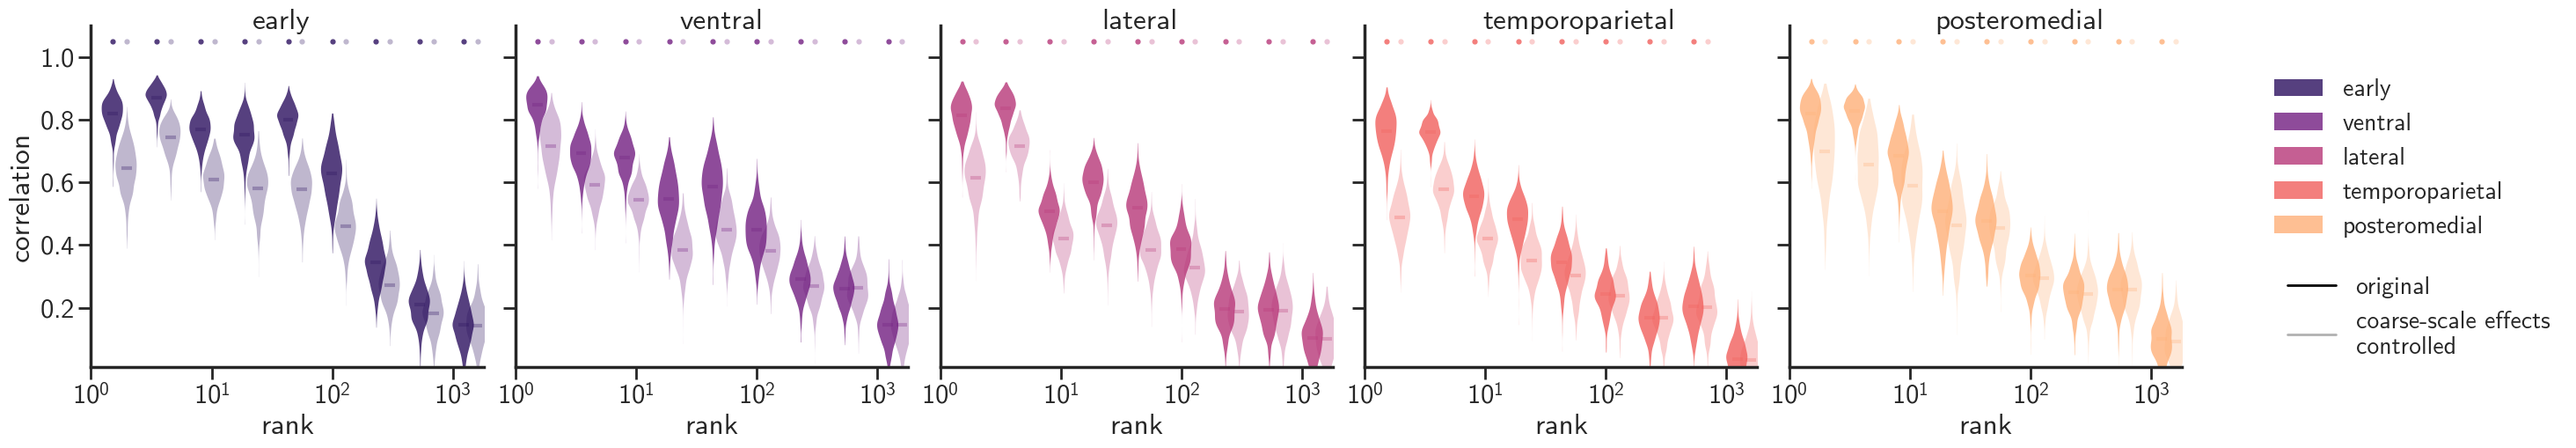

In [27]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

alpha = 0.05
figure, axes = plt.subplots(1, 5, figsize=(25, 5))
plt.rcParams.update({
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'figure.constrained_layout.use': True,
    'figure.constrained_layout.w_pad': 0.05,
    'figure.constrained_layout.h_pad': 0.05,
})
# set color map
idm_roi_colors = sns.color_palette("magma", n_colors=len(rois))

for n_roi, roi in enumerate(rois):
    for n_bin, bin in enumerate(unique_bins):
        # Get bootstrap samples for both conditions
        samples_isc = np.array([sp[n_bin] for sp in roi_boot_corrs_isc[roi]])
        samples = np.array([sp[n_bin] for sp in roi_boot_corrs[roi]])
        
        # Create positions for the violin plots
        pos = bin if bin > 1 else 1  # Ensure we don't have 0 position for log scale
        
        # Width needs to scale linearly with x to maintain constant visual width in log space
        # Base width is 0.2 (20% of the value)
        width = pos * 0.4  
        
        # Create violin plots with adjusted widths
        v1 = axes[n_roi].violinplot(samples_isc, [pos * 1.3], points=100,
                                  widths=[pos * 1.3 * 0.4],  # Scale width with shifted position
                                  showmeans=True, showextrema=False)
        v2 = axes[n_roi].violinplot(samples, [pos], points=100,
                                  widths=[width],
                                  showmeans=True, showextrema=False)
        
        # Style the violin plots
        # ISC-controlled (solid)
        v1['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v1['bodies'][0].set_alpha(0.3)
        v1['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v1['cmeans'].set_alpha(0.3)
        #v1['cmins'].set_color(idm_roi_colors[rois.index(roi)])
        #v1['cmaxes'].set_color(idm_roi_colors[rois.index(roi)])
        #v1['cbars'].set_color(idm_roi_colors[rois.index(roi)])
        
        # Original correlations (transparent)
        v2['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v2['bodies'][0].set_alpha(0.8)
        v2['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v2['cmeans'].set_alpha(0.3)
        #v2['cmins'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cmins'].set_alpha(0.3)
        #v2['cmaxes'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cmaxes'].set_alpha(0.3)
        #v2['cbars'].set_color(idm_roi_colors[rois.index(roi)])
        #v2['cbars'].set_alpha(0.3)
        
        #Add significance testing if needed
        if bin in significance_isc[roi]:
            axes[n_roi].scatter(pos * 1.3, 1.05, color=idm_roi_colors[n_roi], alpha=0.3, s=20)
        if bin in significance[roi]:
            axes[n_roi].scatter(pos, 1.05, color=idm_roi_colors[n_roi], alpha=0.8, s=20)
          
    
    # Set scales and limits
    axes[n_roi].set_xscale('log')
    axes[n_roi].set_xlabel('rank')
    axes[n_roi].set_xlim(1, 1800)
    axes[n_roi].set_ylim(10e-3, 1.10)
    axes[n_roi].tick_params(axis='both', which='major', length=10, width=2)

    # Set labels and ticks
    if n_roi == 0:
        axes[n_roi].set_ylabel("correlation")
    else:
        axes[n_roi].set_yticklabels([])
        axes[n_roi].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

# Add legend (original - solid, coarse-scale effects controlled - transparent) on the right side
legend_elements = [Line2D([0], [0], color='black', lw=2, label='original'),
                   Line2D([0], [0], color='black', lw=2, alpha=0.3, label='coarse-scale effects \ncontrolled')]
figure.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.175, 0.45), fontsize=20)
# Add ROI legend
roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
figure.legend(roi_patches, ['early', 'ventral', 'lateral', 'temporoparietal', 'posteromedial'], 
            bbox_to_anchor=(1.15, 0.9),
            loc='upper right', 
            frameon=False, 
            fontsize=20)

# Add titles and labels
#figure.text(0.5, 0, 'rank', ha='center', fontsize=24)
figure.text(0.13, 0.95, 'early', ha='center', va='bottom', fontsize=24)
figure.text(0.33, 0.95, 'ventral', ha='center', va='bottom', fontsize=24)
figure.text(0.52, 0.95, 'lateral', ha='center', va='bottom', fontsize=24)
figure.text(0.72, 0.95, 'temporoparietal', ha='center', va='bottom', fontsize=24)
figure.text(0.92, 0.95, 'posteromedial', ha='center', va='bottom', fontsize=24)

#plt.show()
plt.savefig('figure2_violin_perm.svg', format='svg', dpi=300, transparent=True)

- Compute permuted IDM correlations

In [24]:
def permute_idm_series(args, n_permutations=1000):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)

    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})

    bin_strategy = None
    analysis = IDMAnalysis(cache, bin_strategy)

    permuted_series = {movie: [] for movie in movies}
    if args.isc:
        file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_permuted_fp_isc_{str(n_permutations)}.pkl"
    else:
        file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_permuted_fp_{str(n_permutations)}.pkl"
    if os.path.exists(file):
        permuted_series = pickle.load(open(file, "rb"))
    else:
        for p in tqdm(range(n_permutations)):
            with h5py.File(h5_data_path, 'r') as h5f:
                for movie in movies:
                    all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
                    perm_i = np.random.permutation(subjects)
                    perm_j = np.random.permutation(subjects)
                    for i, i_subject in enumerate(perm_i):
                        for j, j_subject in enumerate(perm_j):
                            if i_subject != j_subject:
                                try:
                                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                                except:
                                    spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:min_length]
                                for n_bin, bin_id in enumerate(unique_bins):
                                    try:
                                        all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                                        all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                                    except Exception as e:
                                        continue
                    permuted_series[movie].append(np.moveaxis(all_spectra, -1, 0))
        with open(file, "wb") as f:
            pickle.dump(permuted_series, f)
            
    return permuted_series

for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/_individual_dim/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/home/chan21/idim-debug-spectra/results/isc_{roi}_functional/eigenspectra.h5", #"/data/chan21/indiv_diff_dim/results/n=39/isc_occipital_functional/eigenspectra.h5",
        anatomical=False,
        #anatomical_dir="/path/to/anatomical_matrices"
    )

    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None       

    permuted_series = permute_idm_series(args)

    for perm_idx in range(1000):
        permuted_idm1 = np.nanmean([permuted_series[movie][perm_idx] for movie in config.movies[::2]], axis=0)
        permuted_idm2 = np.nanmean([permuted_series[movie][perm_idx] for movie in config.movies[1::2]], axis=0)

        if args.isc:
            corr = np.zeros((len(unique_bins)))
            for n_bin in range(len(unique_bins)):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_upper_triangle(permuted_idm1[n_bin]),
                    get_upper_triangle(permuted_idm2[n_bin]),
                    get_upper_triangle(even_motion1),
                    get_upper_triangle(odd_motion1))
                _, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_motion2),
                    get_upper_triangle(odd_motion2))
                r, _, _ = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_anat),
                    get_upper_triangle(odd_anat))
                corr[n_bin] = r
            roi_perm_corrs_isc[roi].append(corr)
        else:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_upper_triangle(permuted_idm1[n_bin]),
                    get_upper_triangle(permuted_idm2[n_bin]),
                    get_upper_triangle(even_motion1),
                    get_upper_triangle(odd_motion1))
                r, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_upper_triangle(even_motion2),
                    get_upper_triangle(odd_motion2))
                #print(r)
                corr[n_bin] = r
            roi_perm_corrs[roi].append(corr)

        diagonals = np.zeros((len(unique_bins), len(unique_bins)))
        for i, bin in enumerate(unique_bins):
            permuted_idm1_tri = permuted_idm1[i][np.triu_indices(permuted_idm1[i].shape[1], k=1)]
            for j, bin in enumerate(unique_bins):
                diagonals[i, j] = np.corrcoef(permuted_idm1_tri, permuted_idm2[j][np.triu_indices(permuted_idm2[j].shape[1], k=1)])[0, 1]
        if args.isc:
            roi_perm_split_corrs_isc[roi].append(diagonals)
        else:
            roi_perm_split_corrs[roi].append(diagonals)


In [25]:
# # t-test for observed correlation (binned null)

p_values = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs[roi]
    perm_corrs = roi_perm_corrs[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        # Save significance values
        if corrected_pvalue < 0.05:
            significance[roi].append(bin)
p_values_isc = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs_isc[roi]
    perm_corrs = roi_perm_corrs_isc[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values_isc[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        # Save significance values
        if corrected_pvalue < 0.05:
            significance_isc[roi].append(bin)

occipital: 1.5199110829529339 0.833; 8.47; 0.0
occipital: 3.5111917342151306 0.886; 9.609; 0.0
occipital: 8.11130830789687 0.786; 10.095; 0.0
occipital: 18.73817422860384 0.77; 8.984; 0.0
occipital: 43.2876128108306 0.818; 9.588; 0.0
occipital: 100.00000000000004 0.646; 9.925; 0.0
occipital: 231.012970008316 0.353; 9.43; 0.0
occipital: 533.6699231206308 0.213; 6.125; 0.0
occipital: 1232.8467394420663 0.149; 4.487; 0.0
ventral: 1.5199110829529339 0.867; 8.657; 0.0
ventral: 3.5111917342151306 0.707; 11.467; 0.0
ventral: 8.11130830789687 0.698; 11.03; 0.0
ventral: 18.73817422860384 0.57; 9.171; 0.0
ventral: 43.2876128108306 0.604; 9.579; 0.0
ventral: 100.00000000000004 0.463; 10.099; 0.0
ventral: 231.012970008316 0.295; 8.331; 0.0
ventral: 533.6699231206308 0.268; 7.824; 0.0
ventral: 1232.8467394420663 0.152; 4.419; 0.0
temporal: 1.5199110829529339 0.834; 8.192; 0.0
temporal: 3.5111917342151306 0.856; 9.878; 0.0
temporal: 8.11130830789687 0.516; 10.611; 0.0
temporal: 18.73817422860384 0.6

/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


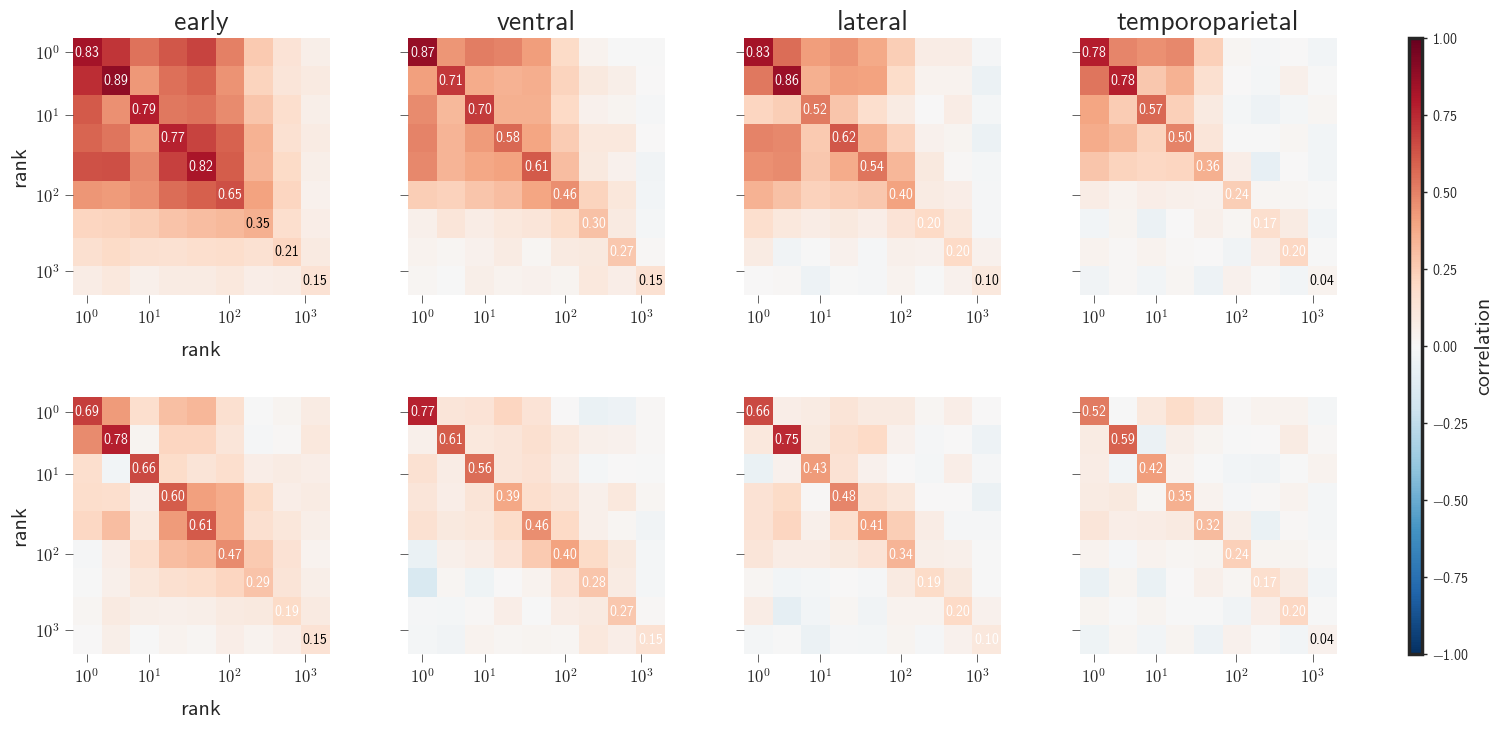

In [ ]:
def create_heatmap_figure(roi_split_corrs, roi_split_corrs_isc, rois):
    fig = plt.figure(figsize=(17.5, 8))
    gs = GridSpec(2, 5, figure=fig, width_ratios=[1, 1, 1, 1, 0.05])
    gs.update(wspace=0.3, hspace=0.4)

    # Create log-scaled tick positions and labels
    rank_values = np.array([1.51991108, 3.51119173, 8.11130831, 18.73817423, 
                           43.28761281, 100., 231.01297001, 533.66992312, 1232.84673944])
    log_ticks = np.array([0, 1, 2, 3])  # Powers of 10
    tick_positions = np.interp(np.power(10, log_ticks), rank_values, np.arange(len(rank_values)))
    tick_labels = [f'$10^{int(p)}$' for p in log_ticks]
    
    for row in [0, 1]:
        data = roi_split_corrs if row == 0 else roi_split_corrs_isc
        
        for col, roi in enumerate(rois):
            ax = fig.add_subplot(gs[row, col])
            diagonals = data[roi]
            
            off_diag_mean = np.mean([diagonals[i,j] for i in range(len(diagonals)) 
                                   for j in range(len(diagonals)) if i != j])
            vmax = max(np.max(diagonals), abs(off_diag_mean))
            
            im = ax.imshow(diagonals, cmap='RdBu_r', vmin=-1, vmax=1)
            
            # Add diagonal values
            for i in range(len(diagonals)):
                ax.text(i, i, f'{diagonals[i,i]:.2f}', 
                       ha='center', va='center', 
                       color='white' if diagonals[i,i] > np.mean(diagonals) else 'black',
                       fontsize=10)
            
            # Add ticks only for the first matrix (row=0, col=0)
            if col == 0:
                ax.set_xticks(tick_positions)
                ax.set_yticks(tick_positions)
                ax.set_xticklabels(tick_labels, fontsize=12)
                ax.set_yticklabels(tick_labels, fontsize=12)
                ax.tick_params(length=6, width=0.5)
                # Add 'rank' label below the ticks
                ax.set_xlabel('rank', labelpad=10, fontsize=16)  # Increased labelpad to move label down
                ax.set_ylabel('rank', fontsize=16)
            else:
                # ax.set_xticks([])
                # ax.set_yticks([])
                ax.set_xticks(tick_positions)
                ax.set_yticks(tick_positions)
                ax.tick_params(length=6, width=0.5)
                ax.set_yticklabels([])
                ax.set_xticklabels(tick_labels, fontsize=12)
            
            # Remove all spines for cleaner presentation
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
         
            # Place title
            if row == 0:
                ax.set_title(rois_names[roi], fontsize=20)
               
    # Add colorbar
    cax = fig.add_subplot(gs[:, -1])
    plt.colorbar(im, cax=cax, label='correlation')
    # Change colorbar label font size
    cax.yaxis.label.set_fontsize(16)
    # Change colorbar tick font size
    cax.tick_params(labelsize=10)

    return fig

# Example usage:
fig = create_heatmap_figure(roi_split_corrs, roi_split_corrs_isc, rois)
plt.show()
#plt.savefig('figure3.svg', dpi=300, bbox_inches='tight', transparent=True)


In [ ]:
def create_difference_figure(roi_split_corrs, roi_split_corrs_isc, rois, unique_bins, idm_roi_colors):
    # Set style
    # plt.style.use('default')
    # plt.rcParams.update({
    #     'font.family': 'Arial',
    #     'font.size': 8,
    #     'axes.labelsize': 8,
    #     'axes.titlesize': 8,
    #     'xtick.labelsize': 8,
    #     'ytick.labelsize': 8,
    #     'axes.linewidth': 0.5,
    #     'xtick.major.width': 0.5,
    #     'ytick.major.width': 0.5,
    #     'xtick.major.size': 3,
    #     'ytick.major.size': 3
    # })

    # Create figure with GridSpec
    fig = plt.figure(figsize=(17.5, 8))
    gs = GridSpec(2, 4, figure=fig)
    gs.update(wspace=0.3, hspace=0.3)

    # Create arrays for major ticks
    major_ticks = np.array([10, 100, 1000])

    # Get global y-limits for difference plots
    all_diffs = []
    for data in [roi_split_corrs, roi_split_corrs_isc]:
        for roi in rois:
            all_diffs.append(calculate_diagonal_differences(data[roi]))
    y_min = min([d.min() for d in all_diffs]) - 0.05
    y_max = max([d.max() for d in all_diffs]) + 0.05

    for row in range(2):  # Two sets (PLS and PLS|ISC)
        data = roi_split_corrs if row == 0 else roi_split_corrs_isc
        
        for col, roi in enumerate(rois):
            ax = fig.add_subplot(gs[row, col])
            diff = calculate_diagonal_differences(data[roi])
            
            # Plot differences
            ax.scatter(unique_bins, diff,
                      color=idm_roi_colors[col],
                      s=30,
                      alpha=0.8)
            
            # Formatting
            ax.set_xscale('log')
            ax.set_xticks(major_ticks)
            ax.minorticks_off()
            ax.set_xticklabels([f'$10^{int(np.log10(t))}$' for t in major_ticks])
            ax.set_ylim(y_min, y_max)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            if col == 0:
                ax.set_ylabel('diagonal dominance')
            else:
                ax.set_yticklabels([])
                ax.set_yticks([0.2, 0.4, 0.6])
            # if row == 1:
            #     ax.set_xlabel('rank')
            
            # # Panel labels and titles
            # label = chr(ord('a') + col + row * len(rois))
            # ax.text(-0.2, 1.05, label, transform=ax.transAxes, 
            #        fontsize=10, fontweight='bold')
            # ax.text(0.5, 1.05, rois_names[roi], transform=ax.transAxes,
            #        ha='center', va='bottom', fontsize=8)
            
            # # Subtle gridlines
            # ax.yaxis.grid(True, linestyle=':', alpha=0.3, zorder=0)
            # ax.set_axisbelow(True)

    # # Add group labels
    # fig.text(0.08, 0.75, 'IDM_PLS', ha='left', va='center', rotation=90, fontsize=9)
    # fig.text(0.08, 0.3, 'IDM_PLS|ISC', ha='left', va='center', rotation=90, fontsize=9)
    
    fig.text(0.5, 0.02, 'rank', ha='center', va='center', fontsize=24)
    return fig

fig_difference = create_difference_figure(roi_split_corrs, roi_split_corrs_isc, rois, unique_bins, idm_roi_colors)
#plt.show()
plt.savefig('figure3b.svg', dpi=300, bbox_inches='tight')
plt.close()

/tmp/ipykernel_4110/3935289891.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('figure3b.svg', dpi=300, bbox_inches='tight')
